In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data loading and processing

## Load dataset of paper labels and metadata

In [2]:
df = pd.read_csv("gigo_noscores_dataset_anon.csv")
#df = pd.read_csv("final_with_metadata_ss_gs_annot_prepost_20190822.csv")

In [3]:
len(df)

164

In [4]:
df[0:3].T

,0,1,2
paper_UID,b7c485f39101623c7b90669f2e27b7fea90d41b7,2717bbfa1a2e553f8739608d95941e1a2ca976c1,f906d92ba005b46d35cc055edf7734d50d897f8b
original classification task,Yes,Yes,Yes
labels from human annotation,Yes,Yes,No
used original human annotation,Yes,Yes,NaN
used external human annotation data,No,No,NaN
original human annotation source,Other,No information,NaN
# of annotators specified,No,Yes,NaN
training for human annotators,No information,No information,NaN
formal instructions,no instructions beyond question text,instructions w/ formal definition or examples,NaN
prescreening for crowdwork platforms,NaN,NaN,NaN


## Recode venue_type into more fine-grained variables

In [5]:
def split_corpus(venue_type):
    if 'Non-ArXived' in str(venue_type):
        return 'Scopus'
    else:
        return 'ArXiv'

In [6]:
df['corpus'] = df['venue_type'].apply(split_corpus)

In [7]:
df['corpus'].value_counts()

ArXiv     135
Scopus     29
Name: corpus, dtype: int64

In [8]:
df['venue_type'].value_counts()

Preprint never published                       57
Postprint of refereed conference proceeding    40
Non-ArXived refereed conference proceedings    23
Preprint of refereed conference proceeding     17
Postprint of refereed journal article           8
Preprint of refereed journal article            7
Non-ArXived refereed journal article            6
Preprint of workshop paper                      3
Postprint of workshop paper                     2
Name: venue_type, dtype: int64

In [9]:
def prepost_consol(venue_type):
    venue_type = str(venue_type)
    if 'Non-ArXived' in venue_type:
        return 'Non-ArXived'
    elif venue_type == 'Preprint never published':
        return venue_type
    elif venue_type[0:9] == 'Postprint':
        return 'Postprint'
    elif venue_type[0:8] == 'Preprint':
        return 'Preprint'
    else:
        return np.nan
    
def venue_consol(venue_type):
    venue_type = str(venue_type)
    if venue_type == 'Preprint never published':
        return venue_type
    elif 'conference' in venue_type:
        return "Conference"
    elif "workshop" in venue_type:
        return 'Workshop'
    elif "journal" in venue_type:
        return 'Journal'
    else:
        return np.nan
    
def prepost_venue_consol(venue_type):
    venue_type = str(venue_type)
    if 'Non-ArXived' in venue_type:
        return 'Non-ArXived'
    elif venue_type == 'Preprint never published':
        return venue_type
    elif venue_type[0:9] == 'Postprint':
        return 'Postprint'
    elif venue_type[0:8] == 'Preprint':
        return 'Preprint'
    else:
        return np.nan

In [10]:
df['venue_type_consol'] = df.venue_type.apply(venue_consol)

In [11]:
df['venue_type_prepost_consol'] = df.venue_type.apply(prepost_consol)

## Calculate annotation information scores

In [12]:
def annot_score_raw(row):
    score = 0
    base_score = 0
    if row['used original human annotation'] != 'Yes':
        return np.nan
    else:
        if row['original human annotation source'] == 'No information':
            base_score += 1
        elif pd.isnull(row['original human annotation source']):
            base_score += 1
        elif len(row['original human annotation source'])>3:
            base_score +=1 
            score += 1
        else:
            raise Exception("Unexpected value")
        
        if row['training for human annotators'] == 'No information':
            base_score += 1
        elif pd.isnull(row['training for human annotators']):
            base_score += 1
        elif len(row['training for human annotators']) >3:
            base_score +=1 
            score += 1  
        else:
            raise Exception("Unexpected value")

        if row['formal instructions '] == 'No information':
            base_score +=1
        elif row['formal instructions '] == 'instructions w/ formal definition or examples':
            base_score +=1
            score += 1
        elif row['formal instructions '] == 'no instructions beyond question text':
            base_score +=1
            score += 1
        elif pd.isnull(row['formal instructions ']):
            base_score += 1
        else:
            raise Exception("Unexpected value")

        if row['original human annotation source'] == 'Other crowdwork' or row['original human annotation source'] == 'Mechanical Turk':
            if row['prescreening for crowdwork platforms'] == 'No information':
                base_score += 1
            elif pd.isnull(row['prescreening for crowdwork platforms']):
                base_score += 1
            elif len(row['prescreening for crowdwork platforms']) > 3:
                score += 1
                base_score += 1
            else:
                raise Exception("Unexpected value")
            
            if row['reported crowdworker compensation'] == 'Yes':
                base_score += 1
                score += 1
            elif row['reported crowdworker compensation'] == 'No':
                base_score += 1
            elif pd.isnull(row['reported crowdworker compensation']):
                base_score += 1
            else:
                raise Exception("Unexpected value")
                
        
        if row['multiple annotator overlap'] == 'No information':
            base_score += 1
        elif row['multiple annotator overlap'] == 'No':
            score += 1
            base_score += 1
        elif pd.isnull(row['multiple annotator overlap']):
            base_score += 1
        elif len(row['multiple annotator overlap']) > 3:
            score += 1
            base_score += 1
        else:
            raise Exception("Unexpected value")
        
        if row['multiple annotator overlap'][0:3] == 'Yes':
            if row['reported inter-annotator agreement'] == 'Yes':
                base_score += 1
                score += 1
            elif row['reported inter-annotator agreement'] == 'No':
                base_score += 1
            elif pd.isnull(row['reported inter-annotator agreement']):
                base_score += 1
            else:
                raise Exception("Unexpected value")
                
        if row['link to dataset available'] == 'Yes':
            base_score += 1
            score += 1
        elif row['link to dataset available'] == 'No':
            base_score += 1
        elif pd.isnull(row['link to dataset available']):
            base_score += 1
        else:
            raise Exception("Unexpected value")
            
        if row['# of annotators specified'] == 'Yes':
            base_score += 1
            score += 1
        elif row['# of annotators specified'] == 'No':
            base_score += 1
        elif pd.isnull(row['# of annotators specified']):
            base_score += 1
        else:
            print(row)
            raise Exception("Unexpected value")
            

        return score
    
    
def annot_score_normalized(row):
    score = 0
    base_score = 0
    if row['used original human annotation'] != 'Yes':
        return np.nan
    else:
        if row['original human annotation source'] == 'No information':
            base_score += 1
        elif pd.isnull(row['original human annotation source']):
            base_score += 1
        elif len(row['original human annotation source'])>3:
            base_score +=1 
            score += 1
        else:
            raise Exception("Unexpected value")
        
        if row['training for human annotators'] == 'No information':
            base_score += 1
        elif pd.isnull(row['training for human annotators']):
            base_score += 1
        elif len(row['training for human annotators']) >3:
            base_score +=1 
            score += 1  
        else:
            raise Exception("Unexpected value")

        if row['formal instructions '] == 'No information':
            base_score +=1
        elif row['formal instructions '] == 'instructions w/ formal definition or examples':
            base_score +=1
            score += 1
        elif row['formal instructions '] == 'no instructions beyond question text':
            base_score +=1
            score += 1
        elif pd.isnull(row['formal instructions ']):
            base_score += 1
        else:
            raise Exception("Unexpected value")

        if row['original human annotation source'] == 'Other crowdwork' or row['original human annotation source'] == 'Mechanical Turk':
            if row['prescreening for crowdwork platforms'] == 'No information':
                base_score += 1
            elif pd.isnull(row['prescreening for crowdwork platforms']):
                base_score += 1
            elif len(row['prescreening for crowdwork platforms']) > 3:
                score += 1
                base_score += 1
            else:
                raise Exception("Unexpected value")
            
            if row['reported crowdworker compensation'] == 'Yes':
                base_score += 1
                score += 1
            elif row['reported crowdworker compensation'] == 'No':
                base_score += 1
            elif pd.isnull(row['reported crowdworker compensation']):
                base_score += 1
            else:
                raise Exception("Unexpected value")
                
        
        if row['multiple annotator overlap'] == 'No information':
            base_score += 1
        elif row['multiple annotator overlap'] == 'No':
            score += 1
            base_score += 1
        elif pd.isnull(row['multiple annotator overlap']):
            base_score += 1
        elif len(row['multiple annotator overlap']) > 3:
            score += 1
            base_score += 1
        else:
            raise Exception("Unexpected value")
        
        if row['multiple annotator overlap'][0:3] == 'Yes':
            if row['reported inter-annotator agreement'] == 'Yes':
                base_score += 1
                score += 1
            elif row['reported inter-annotator agreement'] == 'No':
                base_score += 1
            elif pd.isnull(row['reported inter-annotator agreement']):
                base_score += 1
            else:
                raise Exception("Unexpected value")
                
        if row['link to dataset available'] == 'Yes':
            base_score += 1
            score += 1
        elif row['link to dataset available'] == 'No':
            base_score += 1
        elif pd.isnull(row['link to dataset available']):
            base_score += 1
        else:
            raise Exception("Unexpected value")
            
        if row['# of annotators specified'] == 'Yes':
            base_score += 1
            score += 1
        elif row['# of annotators specified'] == 'No':
            base_score += 1
        elif pd.isnull(row['# of annotators specified']):
            base_score += 1
        else:
            print(row)
            raise Exception("Unexpected value")
            

    return score/base_score


In [13]:
df['annot_score_normalized'] = df.apply(annot_score_normalized, axis=1)
df['annot_score_raw'] = df.apply(annot_score_raw, axis=1)

# Results

## Counts and proportions for each question

In [14]:
def frac_to_percent(df):
    return df.astype(float).map(lambda n: '{:.2%}'.format(n))

In [15]:
def counts_prop_df(df_or_series, dropna=True, labels=True):

    df = pd.concat([pd.DataFrame(df_or_series.value_counts(dropna=dropna)).T,pd.DataFrame(frac_to_percent(df_or_series.value_counts(dropna=dropna, normalize=True))).T])

    if labels is True:
        df.index = [df.index[0] + " (count)", df.index[0] + " (proportion)"]
    else:
        df.index = ["Count", "Proportion"]
    return df

In [16]:
for c in df.columns[1:14]:
    print("---- %s ---" % c)
    print(df[c].value_counts(dropna=False))
    print()    


---- original classification task ---
Yes       142
No         17
Unsure      5
Name: original classification task, dtype: int64

---- labels from human annotation ---
Yes       93
No        46
NaN       21
Unsure     4
Name: labels from human annotation, dtype: int64

---- used original human annotation ---
Yes       72
NaN       68
No        21
Unsure     3
Name: used original human annotation, dtype: int64

---- used external human annotation data ---
NaN       68
No        61
Yes       32
Unsure     3
Name: used external human annotation data, dtype: int64

---- original human annotation source ---
NaN                                 90
Paper's authors                     22
No information                      18
Academic experts / professionals    16
Other crowdwork                      8
Other                                7
Mechanical Turk                      3
Name: original human annotation source, dtype: int64

---- # of annotators specified ---
NaN    90
Yes    41
No     3

## Paper information scores

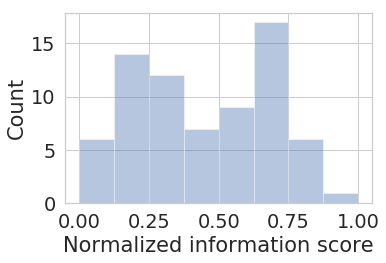

In [17]:
sns.set(style="whitegrid", font_scale=1.75, rc={'figure.figsize':(5.5,3.5)})
ax = sns.distplot(df['annot_score_normalized'].dropna(), bins=8, kde=False)
ax.set_xlabel("Normalized information score")
ax.set_ylabel("Count")
plt.savefig("figures/info_score_normalized_hist.pdf", dpi=300, bbox_inches="tight")
plt.savefig("figures/info_score_normalized_hist.png", bbox_inches="tight")

In [18]:
df['annot_score_normalized'].describe()

count    72.000000
mean      0.441275
std       0.261254
min       0.000000
25%       0.166667
50%       0.428571
75%       0.666667
max       1.000000
Name: annot_score_normalized, dtype: float64

In [19]:
df['annot_score_normalized'].value_counts()

0.166667    14
0.714286    10
0.333333     8
0.666667     6
0.000000     6
0.428571     6
0.571429     4
0.857143     4
0.500000     3
0.285714     3
0.777778     2
0.555556     2
0.444444     1
0.250000     1
1.000000     1
0.625000     1
Name: annot_score_normalized, dtype: int64

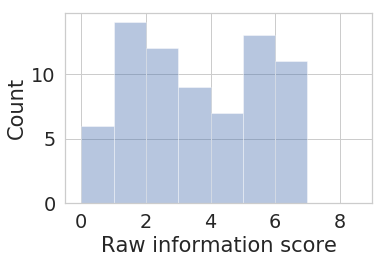

In [20]:
sns.set(style="whitegrid", font_scale=1.75, rc={'figure.figsize':(5.5,3.5)})
ax = sns.distplot(df['annot_score_raw'].dropna(), bins=7, kde=False)
ax.set_xlabel("Raw information score")
ax.set_ylabel("Count")
ax.set_xlim(-0.5,9)
plt.savefig("figures/info_score_raw_hist.pdf", dpi=300, bbox_inches="tight")
plt.savefig("figures/info_score_raw_hist.png", bbox_inches="tight")

In [21]:
df['annot_score_raw'].dropna().value_counts()

1.0    14
5.0    13
2.0    12
3.0     9
6.0     8
4.0     7
0.0     6
7.0     3
Name: annot_score_raw, dtype: int64

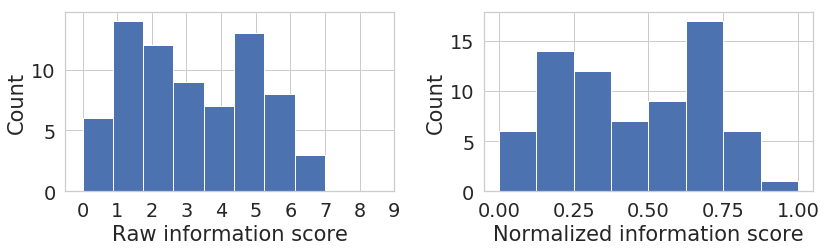

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=[12,4])

sns.set(style="whitegrid", font_scale=1.95)

sns.distplot(df['annot_score_raw'].dropna(), ax=ax[0], bins=8, kde=False, hist_kws={"alpha":1})
ax[0].set_xlabel("Raw information score")
ax[0].set_ylabel("Count")
ax[0].set_xlim(-0.5,8)
ax[0].set_xticks(range(0,10))

sns.distplot(df['annot_score_normalized'].dropna(), ax=ax[1], bins=8, kde=False, hist_kws={"alpha":1})
ax[1].set_xlabel("Normalized information score")
ax[1].set_ylabel("Count")
ax[1].set_xticks(np.arange(0,1.25,.25))


plt.tight_layout()

plt.savefig("figures/info_score_raw_norm_hist.pdf", dpi=300, bbox_inches="tight")
plt.savefig("figures/info_score_raw_norm_hist.png", bbox_inches="tight")

In [23]:
df['annot_score_normalized'].describe()

count    72.000000
mean      0.441275
std       0.261254
min       0.000000
25%       0.166667
50%       0.428571
75%       0.666667
max       1.000000
Name: annot_score_normalized, dtype: float64

In [24]:
df['annot_score_raw'].value_counts(sort=False).sort_index()

0.0     6
1.0    14
2.0    12
3.0     9
4.0     7
5.0    13
6.0     8
7.0     3
Name: annot_score_raw, dtype: int64

In [25]:
df['annot_score_raw'].describe()

count    72.000000
mean      3.152778
std       2.053233
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max       7.000000
Name: annot_score_raw, dtype: float64

## Venue type & corpus-based analyses

In [26]:
venue_type_order = [ 'Preprint never published',
 'Preprint of refereed conference proceeding',
 'Preprint of refereed journal article',
 'Preprint of refereed workshop proceeding',
 'Preprint of workshop paper',
 'Postprint of refereed conference proceeding',
 'Postprint of refereed journal article',
 'Postprint of refereed workshop proceeding',
'Non-ArXived refereed conference proceedings',
 'Non-ArXived refereed journal article',]

In [27]:
venue_type_order = list(df[['venue_type', 'annot_score_normalized']].dropna()['venue_type'].value_counts().sort_index().index)

In [28]:
venue_type_order = list(df[['venue_type', 'annot_score_normalized']].dropna().groupby('venue_type')['annot_score_normalized'].median().sort_values(ascending=False).index)

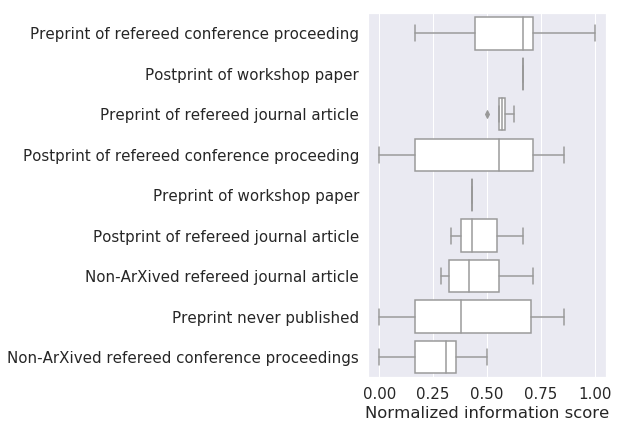

In [29]:
sns.set(style="darkgrid", font_scale=1.37, rc={'figure.figsize':(4.25,6.7)})
ax = sns.boxplot(data=df, x='annot_score_normalized', y='venue_type', order=venue_type_order, color='w')
ax.set_xlabel("Normalized information score")
ax.set_ylabel("")
plt.savefig("figures/info_score_normalized_venue_type.png", bbox_inches="tight")

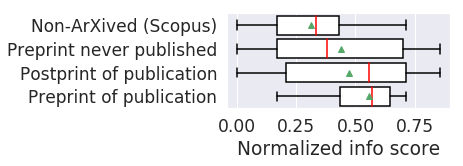

In [30]:
sns.set(style="darkgrid", font_scale=1.55, rc={'figure.figsize':(4,1.75)})
ax = sns.boxplot(data=df, x='annot_score_normalized', y='venue_type_prepost_consol',
                 color='w', medianprops={'color':'red'}, showmeans=True, showfliers=False)
ax.set_xlabel("Normalized info score")
ax.set_ylabel("")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')

ax.set_yticklabels(["Non-ArXived (Scopus)", "Preprint never published", "Postprint of publication", "Preprint of publication"])
plt.savefig("figures/info_score_normalized_venue_type_prepost.png", bbox_inches="tight")
plt.savefig("figures/info_score_normalized_venue_type_prepost.pdf", bbox_inches="tight")

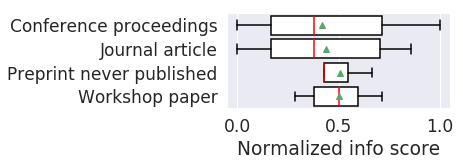

In [31]:
sns.set(style="darkgrid", font_scale=1.55, rc={'figure.figsize':(4,1.75)})
medianprops = dict(linewidth=2.5, linecolor='firebrick')
boxcolors = dict(boxes='r', whiskers='r', medians='r', caps='r')
ax = sns.boxplot(data=df, x='annot_score_normalized', y='venue_type_consol', color='w', medianprops={'color':'red'},
                order = ['Conference', 'Preprint never published', 'Workshop', 'Journal'], showmeans=True)

ax.set_xlabel("Normalized info score")
ax.set_ylabel("")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')

ax.set_yticklabels(["Conference proceedings", "Journal article", "Preprint never published", "Workshop paper"])
plt.savefig("figures/info_score_normalized_venue_type_consol.png", bbox_inches="tight")
plt.savefig("figures/info_score_normalized_venue_type_consol.pdf", bbox_inches="tight")


In [32]:
df['venue_type_consol'].value_counts()

Conference                  80
Preprint never published    57
Journal                     21
Workshop                     5
Name: venue_type_consol, dtype: int64

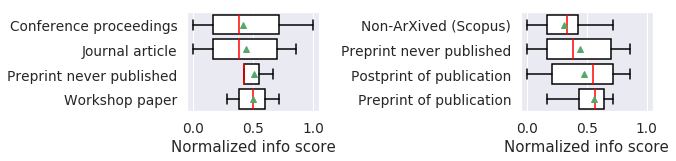

In [33]:
sns.set(style="darkgrid", font_scale=1.25, rc={'figure.figsize':(9.5,2.5)})
medianprops = dict(linewidth=2.5, linecolor='firebrick')
boxcolors = dict(boxes='r', whiskers='r', medians='r', caps='r')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
order = ['Conference', 'Preprint never published', 'Workshop', 'Journal']

sns.boxplot(ax=axs[0], data=df, x='annot_score_normalized', y='venue_type_consol', 
            color='w', medianprops={'color':'red'}, showmeans=True, order=order)

axs[0].set_xlabel("Normalized info score")
axs[0].set_ylabel("")

for l in axs[0].get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')

axs[0].set_yticklabels(["Conference proceedings", "Journal article", "Preprint never published", "Workshop paper"])


sns.boxplot(ax=axs[1], data=df, x='annot_score_normalized', y='venue_type_prepost_consol', 
            color='w', medianprops={'color':'red'}, showmeans=True, showfliers=False)
axs[1].set_xlabel("Normalized info score")
axs[1].set_ylabel("")

for l in axs[1].get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')

axs[1].set_yticklabels(["Non-ArXived (Scopus)", "Preprint never published", "Postprint of publication", "Preprint of publication"])

plt.tight_layout()


plt.savefig("figures/info_score_normalized_venue_type_consol_horiz.png", bbox_inches="tight")
plt.savefig("figures/info_score_normalized_venue_type_consol_horiz.pdf", bbox_inches="tight")


In [34]:
df.venue_type_consol.value_counts()

Conference                  80
Preprint never published    57
Journal                     21
Workshop                     5
Name: venue_type_consol, dtype: int64

In [35]:
df.query("venue_type_consol == 'Workshop'").annot_score_normalized.describe()

count    3.000000
mean     0.507937
std      0.137464
min      0.428571
25%      0.428571
50%      0.428571
75%      0.547619
max      0.666667
Name: annot_score_normalized, dtype: float64

In [36]:
df['venue_type'].value_counts().sort_index()

Non-ArXived refereed conference proceedings    23
Non-ArXived refereed journal article            6
Postprint of refereed conference proceeding    40
Postprint of refereed journal article           8
Postprint of workshop paper                     2
Preprint never published                       57
Preprint of refereed conference proceeding     17
Preprint of refereed journal article            7
Preprint of workshop paper                      3
Name: venue_type, dtype: int64

In [37]:
df.groupby('venue_type_prepost_consol')['annot_score_normalized'].mean()

venue_type_prepost_consol
Non-ArXived                 0.311012
Postprint                   0.473104
Preprint                    0.556097
Preprint never published    0.439153
Name: annot_score_normalized, dtype: float64

In [38]:
df.groupby('venue_type')['annot_score_normalized'].mean()

venue_type
Non-ArXived refereed conference proceedings    0.261905
Non-ArXived refereed journal article           0.458333
Postprint of refereed conference proceeding    0.464286
Postprint of refereed journal article          0.476190
Postprint of workshop paper                    0.666667
Preprint never published                       0.439153
Preprint of refereed conference proceeding     0.598413
Preprint of refereed journal article           0.566964
Preprint of workshop paper                     0.428571
Name: annot_score_normalized, dtype: float64

In [39]:
df['venue_type_consol'].value_counts()

Conference                  80
Preprint never published    57
Journal                     21
Workshop                     5
Name: venue_type_consol, dtype: int64

In [40]:
df['venue_type_prepost_consol'].value_counts()

Preprint never published    57
Postprint                   50
Non-ArXived                 29
Preprint                    27
Name: venue_type_prepost_consol, dtype: int64

In [41]:
df['venue_type'].value_counts().sort_index()

Non-ArXived refereed conference proceedings    23
Non-ArXived refereed journal article            6
Postprint of refereed conference proceeding    40
Postprint of refereed journal article           8
Postprint of workshop paper                     2
Preprint never published                       57
Preprint of refereed conference proceeding     17
Preprint of refereed journal article            7
Preprint of workshop paper                      3
Name: venue_type, dtype: int64

## Publisher-based analyses

In [42]:
df.query('corpus == "ArXiv"').groupby('venue_publisher')['annot_score_normalized'].median().sort_values(ascending=False).index

Index(['ACM', 'ACL', 'Springer', 'Elsevier', 'JMIR', 'UIC', 'AAAI', 'ArXiv', 'Sage', 'IEEE', 'ISCRAM', 'CEUR', 'PloS'], dtype='object', name='venue_publisher')

In [43]:
df.query('corpus == "Scopus"').groupby('venue_publisher')['annot_score_normalized'].median().sort_values(ascending=False).index

Index(['Elsevier', 'Springer', 'IEEE', 'ACM', 'SPC'], dtype='object', name='venue_publisher')

In [44]:
pub_order_arxiv = ['ACM', 'ACL', 'Springer', 'Elsevier', 'JMIR', 'UIC', 'ArXiv', 'Sage', 'AAAI', 'IEEE', 'ISCRAM']

In [45]:
pub_order_scopus = ['Elsevier', 'Springer', 'IEEE', 'ACM']

In [46]:
df.query('corpus == "ArXiv"').groupby('venue_publisher')['annot_score_normalized'].describe()

,count,mean,std,min,25%,50%,75%,max
venue_publisher,,,,,,,,
AAAI,3.0,0.425926,0.250514,0.166667,0.305556,0.444444,0.555556,0.666667
ACL,7.0,0.593537,0.245945,0.250000,0.428571,0.666667,0.690476,1.000000
ACM,7.0,0.561224,0.228222,0.166667,0.444444,0.666667,0.714286,0.777778
ArXiv,18.0,0.439153,0.289335,0.000000,0.166667,0.380952,0.702381,0.857143
CEUR,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elsevier,2.0,0.603175,0.246926,0.428571,0.515873,0.603175,0.690476,0.777778
IEEE,10.0,0.373810,0.327817,0.000000,0.166667,0.226190,0.702381,0.857143
ISCRAM,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
JMIR,1.0,0.571429,NaN,0.571429,0.571429,0.571429,0.571429,0.571429


In [47]:
df.query('corpus == "Scopus"').groupby('venue_type_consol')['annot_score_normalized'].describe()

,count,mean,std,min,25%,50%,75%,max
venue_type_consol,,,,,,,,
Conference,12.0,0.261905,0.163072,0.000000,0.166667,0.309524,0.357143,0.500000
Journal,4.0,0.458333,0.193795,0.285714,0.321429,0.416667,0.553571,0.714286


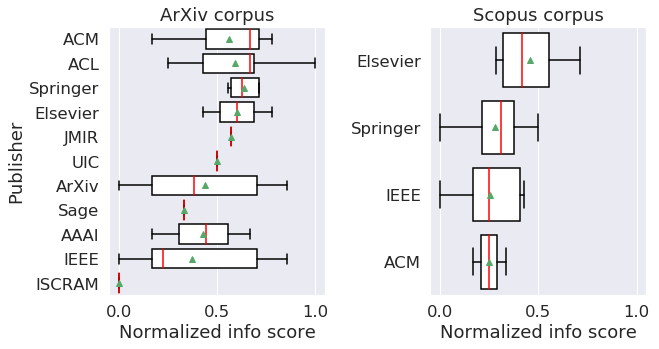

In [48]:
sns.set(style="darkgrid", font_scale=1.5, rc={'figure.figsize':(9.5,5.0)})

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)


sns.boxplot(ax=ax[0], data=df.query('corpus == "ArXiv"'), x='annot_score_normalized',
                 y='venue_publisher', color='w', order=pub_order_arxiv, medianprops={'color':'red'}, showmeans=True)

ax[0].set_xlabel("Normalized info score")
ax[0].set_ylabel("Publisher")

for l in ax[0].get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')
            
sns.boxplot(ax=ax[1], data=df.query('corpus == "Scopus"'), x='annot_score_normalized', y='venue_publisher',
            color='w', order=pub_order_scopus, medianprops={'color':'red'}, showmeans=True)

ax[1].set_xlabel("Normalized info score")
ax[1].set_ylabel("")

for l in ax[1].get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        if l.get_color() != 'red':
            l.set_color('black')            

        
#ax[1].set_xlim(-0.05,1)

plt.tight_layout()
            
ax[0].set_title("ArXiv corpus")
ax[1].set_title("Scopus corpus")
plt.savefig("figures/info_score_norm_publisher_arxiv.png", bbox_inches="tight")
plt.savefig("figures/info_score_norm_publisher_arxiv_scopus.pdf", bbox_inches="tight")

#plt.setp()

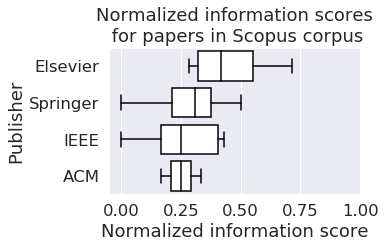

In [49]:
sns.set(style="darkgrid", font_scale=1.5, rc={'figure.figsize':(4.5,2.7)})

ax = sns.boxplot(data=df.query('corpus == "Scopus"'), x='annot_score_normalized', y='venue_publisher', color='w', order=pub_order_scopus)
ax.set_xlabel("Normalized information score")
ax.set_ylabel("Publisher")

for l in ax.get_children():
    if type(l) == matplotlib.patches.PathPatch:
        l.set_edgecolor('black')
    if type(l) == matplotlib.lines.Line2D:
        l.set_color('black')
        
ax.set_xlim(-0.05,1)

plt.title("Normalized information scores\n for papers in Scopus corpus")
plt.savefig("figures/info_score_norm_publisher_scopus.png", bbox_inches="tight")

## Keyword-based analyses

In [50]:
df = pd.concat([df, df.keywords.str.get_dummies(sep='; ').add_prefix('kw: ')], axis=1)

In [51]:
kw_cols = []
for col in df.columns:
    if 'kw:' in col:
        kw_cols.append(col)

In [52]:
kw_counts = df[kw_cols].sum().sort_values() 

In [53]:
kw_counts

kw: activism                       1
kw: information propagation        1
kw: language identification        1
kw: location detection             1
kw: traffic                        1
kw: marketing                      1
kw: personality classification     1
kw: ideology detection             1
kw: personality detection          1
kw: prediction markets             1
kw: public safety                  1
kw: religion                       1
kw: search engine optimization     1
kw: security vulnerabilities       1
kw: sports                         1
kw: phishing                       1
kw: humor/irony-detection          1
kw: location prediction            1
kw: consumer prediction            1
kw: criminal justice               1
kw: gang prediction                1
kw: figures of speech              1
kw: event detection                1
kw: entity recognition             1
kw: cultural studies               2
kw: personality prediction         2
kw: employment prediction          2
k

In [54]:
df = df.drop(kw_counts[kw_counts < 3].index, axis=1)

In [55]:
kw_cols = []
for col in df.columns:
    if 'kw:' in col:
        kw_cols.append(col)

In [56]:
df_list = []
for col in kw_cols:
    #print(col)
    temp_df = pd.DataFrame(df[df[col]==1]['annot_score_normalized']).T
    temp_df.index = [col]
    df_list.append(temp_df)

In [57]:
df_list[2]

,103,131,136,137,146,148,158,161
kw: content moderation,0.166667,NaN,0.444444,0.666667,0.428571,0.714286,NaN,0.857143


In [58]:
df_list[8]

,2,24,88,129
kw: finance,NaN,NaN,0.0,NaN


In [59]:
df_quality_norm_kw = pd.concat(df_list)
df_quality_norm_kw[5:8]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163
kw: demographic prediction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kw: elections,NaN,0.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.714286,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
kw: epidemology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_quality_norm_kw.count(axis=1).sort_values()

kw: humor/irony detection      0
kw: recommender systems        0
kw: social computing           0
kw: demographic prediction     1
kw: finance                    1
kw: journalism                 2
kw: sockpuppet detection       3
kw: spam prediction            3
kw: psychology                 3
kw: terrorism                  3
kw: computer vision            4
kw: bot prediction             5
kw: crisis informatics         5
kw: epidemology                6
kw: stance detection           6
kw: elections                  6
kw: content moderation         6
kw: human geography            6
kw: social influence           6
kw: social networks            7
kw: hate speech                8
kw: cybersecurity              8
kw: information quality        9
kw: non-English               10
kw: public health             11
kw: political science         13
kw: sentiment analysis        13
kw: topic identification      15
kw: public opinion            19
kw: user profiling            21
dtype: int

In [61]:
kw_paper_counts = pd.concat([kw_counts,df_quality_norm_kw.count(axis=1).sort_values()], axis=1)
kw_paper_counts.columns=['all papers in corpus', 'papers using original human annotation']
kw_paper_counts = kw_paper_counts.sort_values('all papers in corpus', ascending=False)[0:29]

/opt/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [62]:
kw_paper_counts['papers not using original human annotation'] = kw_paper_counts['all papers in corpus'] - kw_paper_counts['papers using original human annotation']

In [63]:
kw_pc_idx = kw_paper_counts.index
new_kw_pc_idx = []
for kw in kw_pc_idx:
    new_kw_pc_idx.append(kw[4:])
kw_paper_counts.index = new_kw_pc_idx

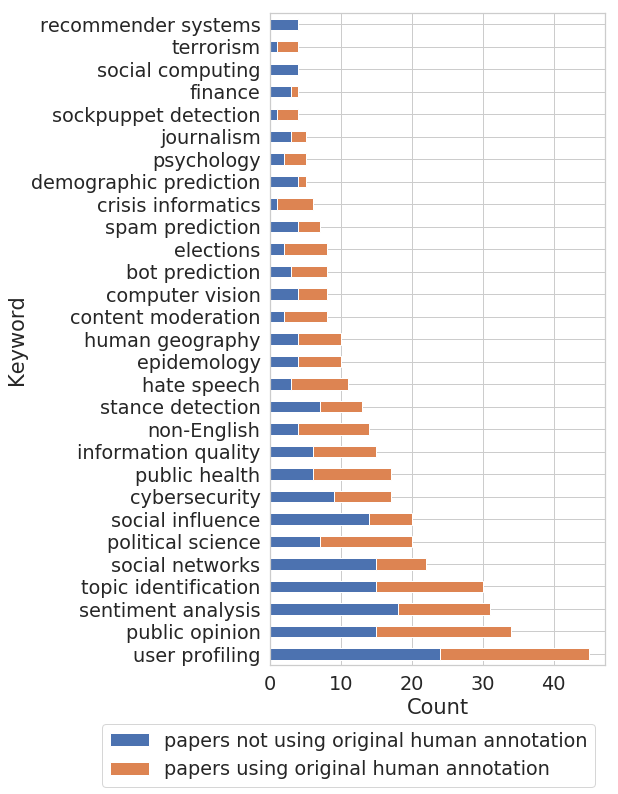

In [64]:
sns.set(font_scale=1.75, style="whitegrid")
ax = kw_paper_counts[['papers not using original human annotation', 'papers using original human annotation']].plot(kind='barh',stacked=True, figsize=[6,12])
ax.set_xlabel("Count")
ax.set_ylabel("Keyword")
ax.legend(bbox_to_anchor=(1,-.075))
plt.savefig("figures/keyword-count.pdf", dpi=300, bbox_inches="tight")

In [65]:
import csv
export_cols = ['paper_UID', 'original classification task', 'labels from human annotation', 'used original human annotation', 'used external human annotation data', 'original human annotation source', '# of annotators specified', 'training for human annotators', 'formal instructions ', 'prescreening for crowdwork platforms', 'multiple annotator overlap', 'reported inter-annotator agreement', 'reported crowdworker compensation', 'link to dataset available', 'annot_score_normalized', 'annot_score_raw', 'corpus','keywords', 'venue_publisher', 'venue_type', 'venue_type_consol', 'venue_type_prepost_consol']
df[export_cols].to_csv("gigo_final_dataset_anon.csv",index=False,quoting=csv.QUOTE_NONNUMERIC)